In [206]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
import numpy as np

In [207]:
for file in set(os.listdir(os.path.join(os.curdir, 'predictions'))):
    df = pd.read_csv(os.path.join(os.curdir, 'predictions', file))
    df.domain = df.domain.str.replace(pat="('", repl='')
    df.domain = df.domain.str.replace(pat="',)", repl='')
    df.domain = df.domain.str.strip()
    print(f'{file} : ')
    print(r2_score(y_true=df.true, y_pred=df.prediction))
    print(mean_squared_error(y_true=df.true, y_pred=df.prediction))
    print(explained_variance_score(y_true=df.true, y_pred=df.prediction))

Results.csv : 
0.7768123734920344
35.74058127018299
0.8248637586486183
gcn_grounded_conv_impr=True_11epochs.csv : 
0.852639851742759
17.871536821084714
0.8535568206775699
conv_gcn_grounded.csv : 
0.8877579440730622
13.61248654467169
0.8879001462951697
results_transferLearning_conv_grounded_GCN_8epochs.csv : 
0.957291938520629
12.661605206073753
0.9575399314316663
conv_grounded_results_transferLearning_4Epochs.csv : 
0.9592821034550797
12.071583514099784
0.960274075099229
gcn_grounded_gnn_impr=True_12epochs.csv : 
0.8505198267982877
18.12864910215135
0.8710614653812756
per_domain_dual.csv : 
0.8051786755710308
28.34056399132321
0.805182589487226
conv_per_domain_grounded_graphSizeSplit.csv : 
0.8801986560506284
35.517353579175705
0.8805873859306511
gcn_grounded_gnn_impr=True_bias=False.csv : 
0.8269499666242888
20.987153446433865
0.8303158878528862
gcn_grounded_gnn.csv : 
0.8669710632426899
16.13347685683531
0.8712598685036448
handcrafted_dual.csv : 
0.14173993908742832
109.1205597416577

In [208]:
df = pd.read_csv('./predictions/gcn_grounded_conv_graphSizeSplit.csv')
df.domain = df.domain.str.replace(pat="('", repl='')
df.domain = df.domain.str.replace(pat="',)", repl='')
df.domain = df.domain.str.strip()

mse_list = []
for domain in df.domain.unique():
    mse = mean_squared_error(y_true=df[df.domain == domain].true, y_pred=df[df.domain == domain].prediction)
    print(f'MSE of {domain} : {mse}')
    mse_list.append(mse)


df = pd.read_csv('./predictions/conv_per_domain_grounded_graphSizeSplit.csv')
df.domain = df.domain.str.replace(pat="('", repl='')
df.domain = df.domain.str.replace(pat="',)", repl='')
df.domain = df.domain.str.strip()

mse_list2 = []
for domain in df.domain.unique():
    mse = mean_squared_error(y_true=df[df.domain == domain].true, y_pred=df[df.domain == domain].prediction)
    print(f'MSE of {domain} : {mse}')
    mse_list2.append(mse)

print('normal, per_domain')
for d, i,j in zip(df.domain.unique(), mse_list, mse_list2):
    print(d, i, j)

MSE of floortile : 64.48314606741573
MSE of zenotravel : 13.76271186440678
MSE of visitall : 65.28888888888889
MSE of hiking : 37.39473684210526
MSE of depots : 2.4918032786885247
MSE of miconic : 14.551020408163266
MSE of childsnack : 2.242424242424242
MSE of woodworking : 0.9298245614035088
MSE of logistics : 2.6805555555555554
MSE of data_network : 7.3125
MSE of parking : 6.5625
MSE of rovers : 230.1290322580645
MSE of transport : 129.01666666666668
MSE of maintenance : 0.38095238095238093
MSE of driverlog : 180.4078947368421
MSE of barman : 63.34375
MSE of scanalyzer : 27.405405405405407
MSE of blocksworld : 3983.8333333333335
MSE of gripper : 95.0
MSE of barman : 123.40625
MSE of blocksworld : 125.72727272727273
MSE of childsnack : 0.84375
MSE of data_network : 10.8125
MSE of depots : 20.491803278688526
MSE of driverlog : 55.43421052631579
MSE of floortile : 13.606741573033707
MSE of gripper : 16.666666666666668
MSE of hiking : 3.973333333333333
MSE of logistics : 1.77777777777777

NOTES ABOUT PER_DOMAIN Vs NORMAL
- There are domains such as woodworking, childsnack and maintenance where the target label doesnt vary a lot between instances. In these domains, the results show that the model solely trained on that specific domain (per domain) is achieving near zero errors, while the one-dataset "normal" model has more trouble since its parameters are also optimized for encountering all other domains. In these domains per_domain clearly wins, since it in those cases just has to converge to predicting the most common labels. 
- But in some domains such as transport and visitall (where the target label varies relatively more), the normal model outperforms the per_domain model significantly. This is assumably due to the fact that the general underlying structures of the grounded graphs are best learned on the dataset that contains the graphs of all the domains, and not the dataset with a few hundred instances in the per domain model. 

Question: 
- Is it possible to get some kind of hybrid model which achieves the best of both worlds?

Initial thought: 
- Transfer learning, with fixation of the parameters of the convolution modules to make sure the parameters that are responsible for learning the features of the graph structures are kept intact, and the ffnn is altered such that the domains with low variance target labels are still predicted well. 
Problem with this idea : Running the model has shown that the convolution module is responsible for achieving a 0.91 R2 score, and is therefore probably of great importance to learn the underlying structures of the graphs of a domain. When we fix the parameters of the convolution module, we aren't able to use this important module to learn from the graphs of the target domain. So target learning with fixation is most likely no solution. 

Hypothesis: 
- Domain adaptation using finetuning on the target domain using all the parameters will achieve the best of both worlds. 



Transfer learning experiment testing hypothesis : 

- First fully train on all the other domains, afterwards train similar amount of epochs on target domain train set. 
- Barman result seems to achieve the mean of the per_domain and normal model results. 

Ideas for other experiments : 
- Interweve transfer train set in train set with all other domains, and after initial cycle, additionally train an epoch (or a few) (possibly fixating certain parameters of the model or not). 
- Add an additional layer at the end of the FFNN that results of the above, and only train that additional layer on a few epochs of the target domain. 

In [209]:
df = pd.read_csv('./predictions/results_transferLearning_conv_grounded_GCN_8epochs.csv')

In [210]:
print(list(zip(df.domain, df.true, df.prediction)))

[('gripper', 14, 13), ('gripper', 16, 15), ('gripper', 16, 14), ('rovers', 44, 42), ('rovers', 46, 39), ('rovers', 43, 39), ('rovers', 34, 38), ('rovers', 43, 41), ('rovers', 49, 44), ('rovers', 7, 11), ('rovers', 44, 40), ('rovers', 44, 40), ('rovers', 43, 38), ('rovers', 49, 46), ('rovers', 34, 37), ('rovers', 44, 42), ('rovers', 7, 11), ('rovers', 49, 44), ('rovers', 44, 42), ('rovers', 43, 38), ('rovers', 34, 35), ('rovers', 49, 47), ('rovers', 43, 40), ('rovers', 7, 11), ('rovers', 7, 12), ('rovers', 43, 37), ('rovers', 46, 39), ('rovers', 49, 44), ('rovers', 34, 35), ('rovers', 44, 37), ('rovers', 27, 44), ('rovers', 44, 40), ('rovers', 34, 36), ('rovers', 43, 39), ('rovers', 34, 37), ('rovers', 44, 41), ('rovers', 49, 42), ('rovers', 44, 39), ('rovers', 7, 11), ('rovers', 43, 39), ('rovers', 34, 36), ('rovers', 44, 43), ('rovers', 34, 35), ('rovers', 44, 41), ('rovers', 44, 41), ('rovers', 43, 39), ('rovers', 34, 34), ('rovers', 46, 37), ('rovers', 34, 36), ('rovers', 37, 38), (

In [211]:
print(r2_score(y_true=df.true, y_pred=df.prediction))
print(mean_squared_error(y_true=df.true, y_pred=df.prediction))

0.957291938520629
12.661605206073753


In [212]:

df2 = pd.read_csv('./predictions/conv_per_domain_grounded_graphSizeSplit.csv')
df2.domain = df2.domain.str.replace(pat="('", repl='')
df2.domain = df2.domain.str.replace(pat="',)", repl='')
df2.domain = df2.domain.str.strip()

df2 = df2.sort_values(by=['domain', 'true'])

mse_list3 = []
for domain in df.domain.unique():
    mse = mean_squared_error(y_true=df[df.domain == domain].true, y_pred=df[df.domain == domain].prediction)
    mse_list3.append(mse)

df = df.sort_values(by=['domain', 'true'])

print(df2.head)
print('normal, per_domain, transferLearning\n')
for d, i,j, z in zip(df.domain.unique(), mse_list, mse_list2, mse_list3):
    print(d, i, j, z)

<bound method NDFrame.head of          domain  true  prediction
2        barman    21          42
0        barman    28          43
6        barman    28          43
11       barman    29          45
16       barman    29          44
..          ...   ...         ...
890  zenotravel     9          16
899  zenotravel     9          14
900  zenotravel     9          14
909  zenotravel     9          15
913  zenotravel     9          16

[922 rows x 3 columns]>
normal, per_domain, transferLearning

barman 64.48314606741573 123.40625 2.0
blocksworld 13.76271186440678 125.72727272727273 20.40983606557377
childsnack 65.28888888888889 0.84375 2.675675675675676
data_network 37.39473684210526 10.8125 5.142857142857143
depots 2.4918032786885247 20.491803278688526 12.633333333333333
driverlog 14.551020408163266 55.43421052631579 4.47191011235955
floortile 2.242424242424242 13.606741573033707 1.5972222222222223
gripper 0.9298245614035088 16.666666666666668 0.0
hiking 2.6805555555555554 3.973333333

In [213]:
print(list(zip(df.true, df2.true)))

[(21, 21), (28, 28), (28, 28), (29, 29), (29, 29), (29, 29), (29, 29), (30, 30), (30, 30), (30, 30), (30, 30), (36, 36), (36, 36), (36, 36), (37, 37), (37, 37), (37, 37), (37, 37), (37, 37), (37, 37), (37, 37), (38, 38), (38, 38), (38, 38), (43, 43), (43, 43), (43, 43), (43, 43), (49, 49), (49, 49), (49, 49), (56, 56), (84, 84), (94, 94), (94, 94), (98, 98), (100, 100), (102, 102), (106, 106), (110, 110), (112, 112), (116, 116), (158, 158), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (4, 4), (4, 4), (4, 4), (4, 4), (4, 4), (5, 5), (6, 6), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (8, 8), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (10, 10), (10, 10), (10, 10), (10, 10), (11, 11), (11, 11), (11, 11), (11, 11), (12, 12), (12, 12), (12, 12), (13, 13), (14, 14), (14, 14), (16, 16), (17, 17), (8, 8), (8,

In [214]:
groups = df.groupby('domain')

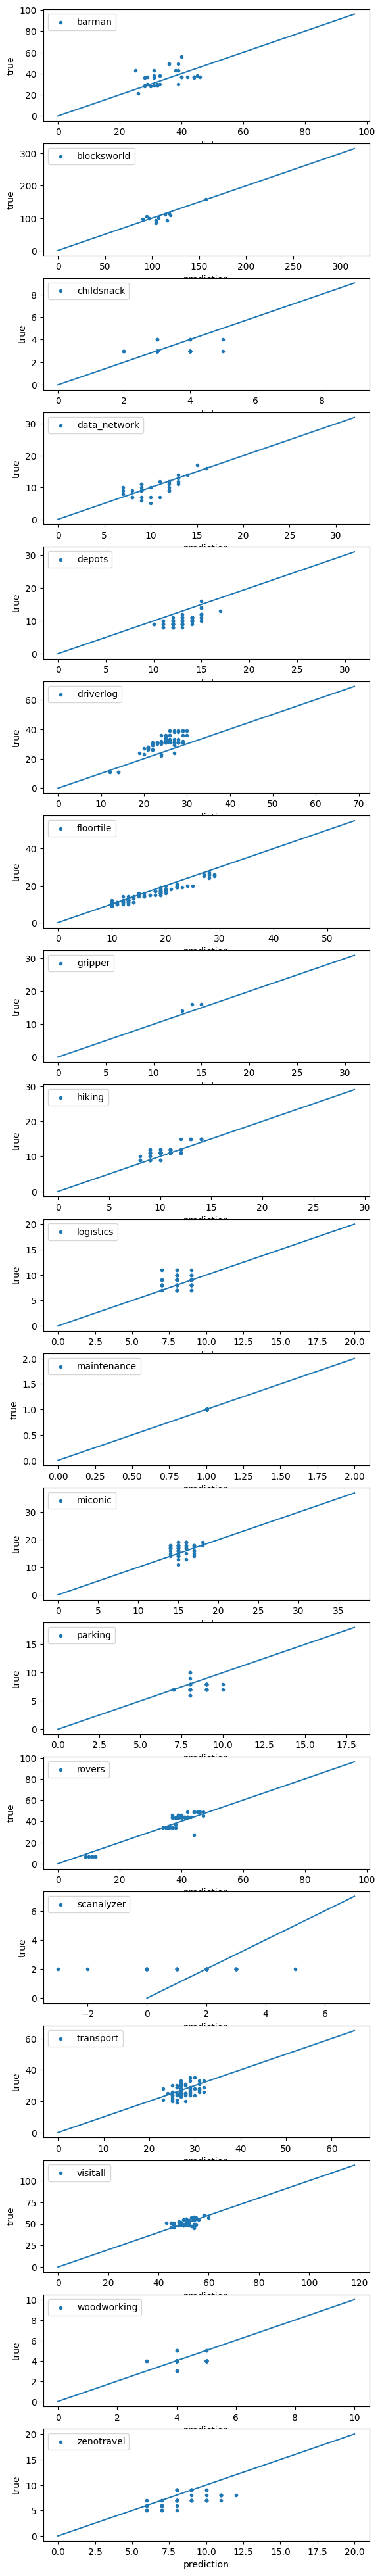

In [215]:
fig, ax = plt.subplots(nrows=len(groups))
for i, (name, group) in enumerate(groups):
    ax[i].scatter(group.prediction, group.true, marker='.', label=name)
    ax[i].figure.set_figheight(50)
    ax[i].plot([0, max(group.prediction+group.true)], [0, max(group.prediction+group.true)])
    ax[i].legend()
    ax[i].set_xlabel('prediction')
    ax[i].set_ylabel('true')
# ax.figure.set_figwidth(10)
plt.show()